In [2]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from torch.nn.functional import normalize
import numpy as np
import os
import io
import math
import random
import os
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import librosa
import librosa.display
import cv2
import cmapy
import nlpaug
import nlpaug.augmenter.audio as naa

from scipy.signal import butter, lfilter

class ICBHI2017(Dataset):

    def __init__(self,
                 train_files_names,
                 train_audio_files_labels,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples):
        self.annotations = train_audio_files_labels
        self.train_files_names=train_files_names
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal=normalize(signal, p=1, dim=0)
        #signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.train_files_names[index]+".wav")
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations[index]
    


if __name__ == "__main__":
    ANNOTATIONS_FILE = "U:\\Motiur Rahman\\RespireNet-main\\data\\ICBHI_final_database\\"
    AUDIO_DIR = "U:\\Motiur Rahman\\RespireNet-main\\data\\ICBHI_final_database\\ICBHI_final_database\\"
    TRAIN_TEST_FILE="ICBHI_challenge_train_test.txt"
    TRAIN_TEST_LABEL="ICBHI_Challenge_diagnosis.txt"
    SAMPLE_RATE = 44100
    NUM_SAMPLES = 882000
    
    
    data_files=pd.read_csv(ANNOTATIONS_FILE+TRAIN_TEST_FILE, sep="\t", header=None, names=["files", "classes"])
    audio_data_files_names=[]
    for i in range(len(data_files)):
        audio_data_files_names.append(data_files['files'][i])
    audio_data_files_names.remove("226_1b1_Pl_sc_Meditron")
    
    
    
    target_values_pd=pd.read_csv(ANNOTATIONS_FILE+TRAIN_TEST_LABEL, sep="\t", header=None, names=["Patient_ID", "Diseases"])
    target_values_pd['classes']=0
    for i in range(len(target_values_pd)):
        if target_values_pd["Diseases"][i]=="Healthy":
            target_values_pd["classes"][i]=0
        else:
            target_values_pd["classes"][i]=1
    target_values_pd=target_values_pd.set_index('Patient_ID')
    
    
    audio_data_files_labels=[]
    for i in range(len(audio_data_files_names)):
        splitted_names=audio_data_files_names[i].split("_")
        audio_data_files_labels.append(target_values_pd.loc[int(splitted_names[0])]['classes'])
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

    icbhi = ICBHI2017(audio_data_files_names,
                            audio_data_files_labels,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES)
    print(f"There are {len(icbhi)} samples in the dataset.")
    signal, label = icbhi[1]

W:\my documents\conda\Motiur\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W:\my documents\conda\Motiur\lib\site-packages\ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
W:\my documents\conda\Motiur\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 919 samples in the dataset.


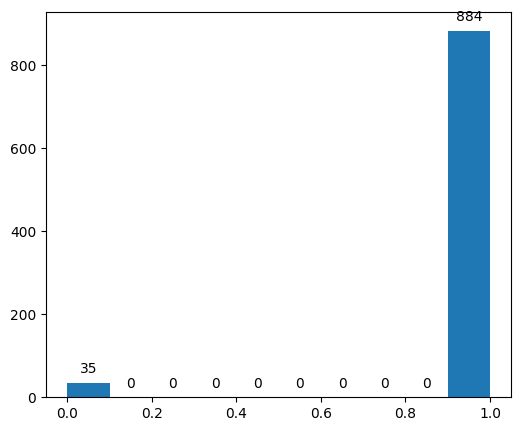

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(audio_data_files_labels, density=False)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

In [4]:
from torch.utils.data import random_split
num_items = len(icbhi)
num_train = round(num_items * 0.8)
num_test = num_items - num_train
train_ds, test_ds = random_split(icbhi, [num_train, num_test])

In [5]:
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.6, max_rate=1.25, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.6)
])
augment2 = Compose([
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.4),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.025, p=0.6)
])
augment3 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.035, p=0.4),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.7),
    TimeStretch(min_rate=0.9, max_rate=1.45, p=0.5)
])
augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.035, p=0.4),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.7),
    TimeStretch(min_rate=0.9, max_rate=1.45, p=0.5)
])
augments=[augment1,augment2,augment3,augment4]

In [6]:
import random
from tqdm import tqdm
train_signal_data=[]
train_signal_labels=[]
for sig, lab in tqdm(train_ds):
    train_signal_data.append(sig)
    train_signal_labels.append(lab)
count=0
print(len(train_signal_data))
augmented_train_files_names=[]
augmented_train_audio_files_labels=[]
for i in tqdm(range(len(train_signal_labels))):
    if train_signal_labels[i]==0:
        for j in range(10):
            augmented_signal=augments[random.randint(0, 3)](train_signal_data[i].numpy(), SAMPLE_RATE)
            augmented_train_files_names.append(torch.tensor(augmented_signal))
            augmented_train_audio_files_labels.append(0)
    else:
        augmented_signal=augments[random.randint(0, 3)](train_signal_data[i].numpy(), SAMPLE_RATE)
        augmented_train_files_names.append(torch.tensor(augmented_signal))
        augmented_train_audio_files_labels.append(1)
print(len(augmented_train_files_names))
print(len(augmented_train_audio_files_labels))

100%|██████████| 735/735 [01:51<00:00,  6.58it/s]


735


100%|██████████| 735/735 [15:02<00:00,  1.23s/it]

960
960


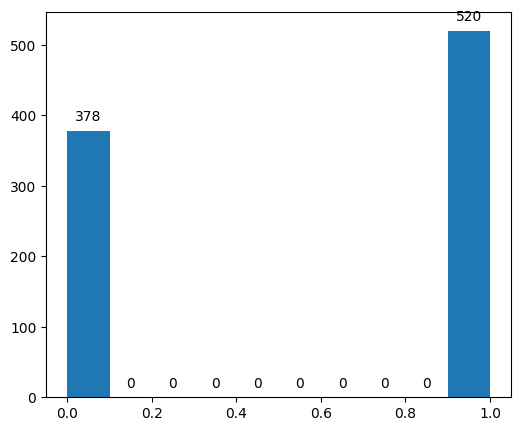

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(augmented_train_audio_files_labels, density=False)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

In [54]:
SAMPLE_RATE=44100
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

def Melspectrogram(current_window, SAMPLE_RATE, input_transform, n_mels=128, f_min=50, f_max=SAMPLE_RATE/2, nfft=2048, hop=512):
    S = librosa.feature.melspectrogram(y=current_window.reshape(current_window.shape[1]), sr=SAMPLE_RATE, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S = librosa.power_to_db(S, ref=np.max)

    S = (S-S.min()) / (S.max() - S.min())
    S *= 255
    #print(S.shape)
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    #print(img.shape)
    height, width, _ = img.shape
    audio_image = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    #print(audio_image.shape)
    audio_img=cv2.cvtColor(audio_image,cv2.COLOR_BGR2RGB)
    #print(audio_img.shape)
    audio_image = cv2.resize(audio_img, (audio_image.shape[1]-1211, 256), interpolation=cv2.INTER_LINEAR)
    #print(audio_image.shape)
    img=input_transform(audio_image)
    #print(img.shape)
    
    return img, S

In [8]:
import torchvision
from torchvision.transforms import ToTensor    
from torch.utils.data import Dataset
class AugmentedDataGeneratorTrain():
    def __init__(self, filtered_test_files_names, filtered_test_audio_files_labels,sr):
        self.filtered_test_audio_files_labels=filtered_test_audio_files_labels
        self.filtered_test_files_names=filtered_test_files_names
        self.sr=sr
    def __len__(self):
        return len(self.filtered_test_audio_files_labels)
    def __getitem__(self, index):
        img, s=Melspectrogram(self.filtered_test_files_names[index].numpy(), self.sr, torchvision.transforms.Compose([ToTensor()]))
        return img, self.filtered_test_audio_files_labels[index]

In [9]:
entire_train_val_data=AugmentedDataGeneratorTrain(augmented_train_files_names, augmented_train_audio_files_labels, 44100)

In [81]:
num_items = len(entire_train_val_data)
num_train = round(num_items * 0.8)
num_test = num_items - num_train
train_ds, val_ds = random_split(entire_train_val_data, [num_train, num_test])

In [82]:
from tqdm import tqdm
train_audio_files_labels=[]
for i, j in tqdm(train_ds):
    train_audio_files_labels.append(j)

100%|██████████| 782/782 [02:04<00:00,  6.26it/s]


In [83]:
from torch.utils.data import WeightedRandomSampler
class_sample_count = np.array(
    [len(np.where(train_audio_files_labels == t)[0]) for t in np.unique(train_audio_files_labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_audio_files_labels])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [84]:
from torch.utils.data import DataLoader
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, sampler=sampler)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [63]:
import torch.nn.functional as F
BATCH_SIZE = 32
EPOCHS = 150
LEARNING_RATE = 0.001

In [66]:
def train_model(model, train_dataloaders,val_dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders=train_dataloaders
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders=val_dataloaders

            running_loss = 0.0
            running_corrects = 0
            i=0
            #print(phase)

            # Iterate over data.
            for inputs, labels in dataloaders:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    
                    #print(len(labels))
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print('{} Batch: {} Loss: {:.4f} Acc: {:.4f}'.format(phase, i, loss.item(), 
                                                                     #torch.sum(preds == labels.data)/len(labels)))
                #i+=1

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [92]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        #print(l_.shape)
        g_ = self.W_g(g)
        #print(g_.shape)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        #print(g_.shape)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

In [93]:
import time
import copy
import torch.nn as nn
from torchvision import *
class AttnResNet(nn.Module):
    def __init__(self, normalize_attn=False):
        super(AttnResNet, self).__init__()
        net = models.resnet34(pretrained=True)
        it=8
        ctrl=1
        for child in net.children():
            if ctrl<it:
                for param in child.parameters():
                    param.requires_grad = False
            ctrl+=1
        self.conv_block1 = net.conv1
        self.bn1=net.bn1
        self.relu=net.relu
        self.maxpool=net.maxpool
        self.layer1=net.layer1
        self.drp=nn.Dropout(p=.5)
        self.layer2=net.layer2
        self.layer3=net.layer3
        self.layer4=net.layer4
        self.avgpool=net.avgpool
        self.flatten=nn.Flatten()
        self.fc=nn.Linear(in_features=768, out_features=2)
        self.sg=nn.Sigmoid()
        self.attn1 = AttentionBlock(256, 512, 256, 2, normalize_attn=normalize_attn)
        #self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
    def forward(self, x):
        out = self.conv_block1(x)       # /1
        #print(out.shape)
        out = self.bn1(out) # /2
        out = self.relu(out)   # /2
        out = self.maxpool(out) # /4
        
        out = self.layer1(out)   # /4
        #out=self.drp(out)
        out = self.layer2(out) # /8
        #out=self.drp(out)
        out1 = self.layer3(out)   # /8
        #out=self.drp(out)    
        out2 = self.layer4(out1) # /16
        #print(out2.shape)
        #out=self.drp(out)
        out = self.avgpool(out2)   # /16
        a,testt=self.attn1(out1,out2)
        #print(testt.shape)
        
        out=self.flatten(out)
        out=torch.cat((out, testt), dim=1)
        out=self.drp(out)
        out = self.fc(out) # /32

        return out

In [94]:
resNet=AttnResNet()

In [95]:
params_to_update = []
for name,param in resNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 fc.weight
	 fc.bias
	 attn1.W_l.weight
	 attn1.W_g.weight
	 attn1.phi.weight
	 attn1.phi.bias


In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, momentum=0.9, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [97]:
model_dict, hist=train_model(resNet, train_dl, val_dl, loss_fn, optimizer,EPOCHS)

Epoch 0/149
----------
train Loss: 0.5898 Acc: 0.6893
val Loss: 0.3092 Acc: 0.8520

Epoch 1/149
----------
train Loss: 0.3614 Acc: 0.8261
val Loss: 0.1952 Acc: 0.9235

Epoch 2/149
----------
train Loss: 0.3006 Acc: 0.8798
val Loss: 0.1745 Acc: 0.9388

Epoch 3/149
----------
train Loss: 0.2282 Acc: 0.8951
val Loss: 0.1497 Acc: 0.9439

Epoch 4/149
----------
train Loss: 0.1785 Acc: 0.9309
val Loss: 0.1694 Acc: 0.9439

Epoch 5/149
----------
train Loss: 0.0959 Acc: 0.9706
val Loss: 0.1379 Acc: 0.9439

Epoch 6/149
----------
train Loss: 0.1059 Acc: 0.9578
val Loss: 0.1312 Acc: 0.9490

Epoch 7/149
----------
train Loss: 0.0608 Acc: 0.9757
val Loss: 0.1420 Acc: 0.9490

Epoch 8/149
----------
train Loss: 0.0774 Acc: 0.9731
val Loss: 0.1654 Acc: 0.9388

Epoch 9/149
----------
train Loss: 0.0650 Acc: 0.9795
val Loss: 0.1342 Acc: 0.9439

Epoch 10/149
----------
train Loss: 0.0272 Acc: 0.9936
val Loss: 0.1429 Acc: 0.9592

Epoch 11/149
----------
train Loss: 0.0294 Acc: 0.9898
val Loss: 0.1330 Acc

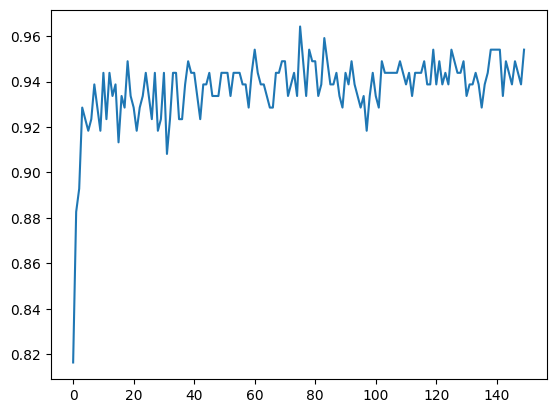

In [75]:
plt.plot(hist)

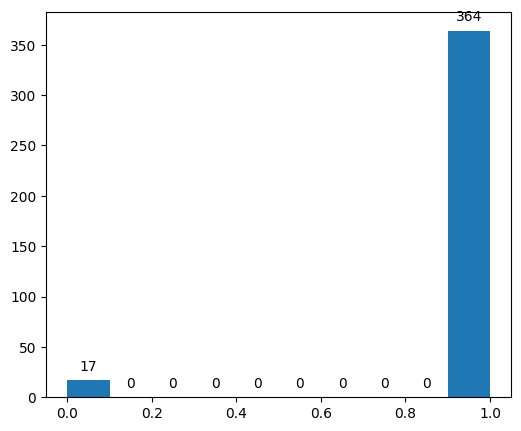

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(test_audio_files_labels, density=False)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

In [99]:
def model_prediction_m(model, test_dataloader):
    model.eval()
    correct=0
    correct0=0
    correct1=0
    total=0
    total0=0
    total1=0
    y_pred = []
    y_true = []
    for inputs, targets in test_dataloader:
        with torch.no_grad():
            prediction = model(inputs)
            _,pred = torch.max(prediction, dim=1)
            output = (torch.max(torch.exp(prediction), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)
            labels = targets.data.cpu().numpy()
            y_true.extend(labels)
            correct+=sum(pred==targets).item()
            for i in range(len(pred)):
                if pred[i].item()==0 and targets[i].item()==0:
                    correct0+=1
                if pred[i].item()==1 and targets[i].item()==1:
                    correct1+=1
            total0=total0+sum(targets==0)
            total1=total1+sum(targets==1)
            total=total+targets.shape[0]
    classes = ('Healthy', 'Unhealthy')
    with open("U:\\Motiur Rahman\\RespireNet-main\\data\\y_pred_two_attention_focal.txt", "w") as output:
        output.write(str(y_pred))
    with open("U:\\Motiur Rahman\\RespireNet-main\\data\\y_true_two_attention_focal.txt", "w") as output:
        output.write(str(y_true))
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    print(f"Overall Test Accuracy={correct/total}")
    print(f"Average Test Accuracy={((correct0/total0)+(correct1/total1))/2}")
    
    print(f"correct={correct}, total={total}, correct0={correct0}, total0={total0}, correct1={correct1}, total1={total1}")
    

In [29]:
from tqdm import tqdm
test_audio_files_files=[]
test_audio_files_labels=[]
for i, j in tqdm(test_ds):
    test_audio_files_files.append(i)
    test_audio_files_labels.append(j)

100%|██████████| 184/184 [00:28<00:00,  6.53it/s]


In [30]:
from torch.utils.data import Dataset
class ClassObjectGenerator(Dataset):
    def __init__(self, audio_files, labels):
        self.labels=labels
        self.audio_files=audio_files     

    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        img, s=Melspectrogram(self.audio_files[index].numpy(), 44100, torchvision.transforms.Compose([ToTensor()]))
        return img, self.labels[index]

In [31]:
testClassObject=ClassObjectGenerator(test_audio_files_files,test_audio_files_labels)

In [101]:
test_dl = torch.utils.data.DataLoader(entire_test_data, batch_size=16, shuffle=False)

Overall Test Accuracy=0.9782608695652174
Average Test Accuracy=0.8693181872367859
correct=180, total=184, correct0=6, total0=8, correct1=174, total1=176


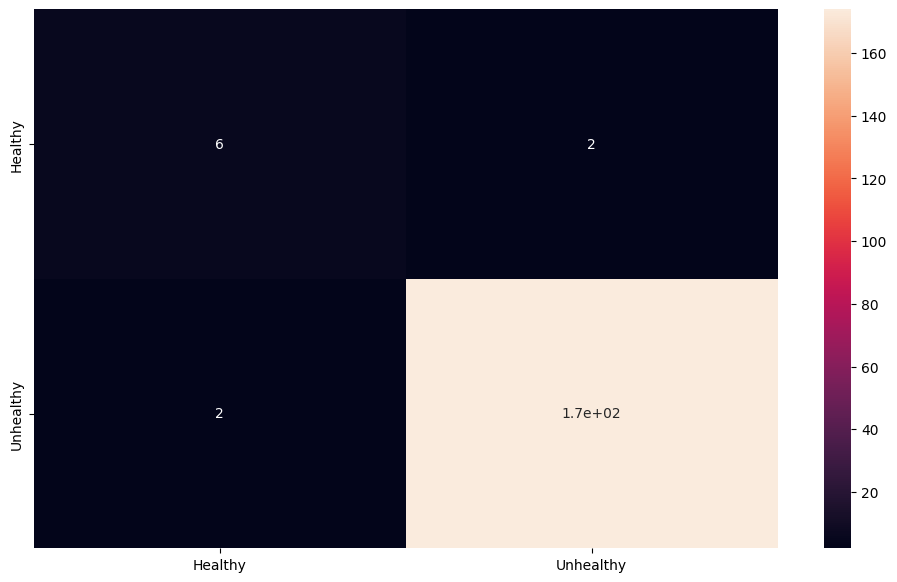

In [103]:
model.load_state_dict(model_dict)
model_prediction_m(model, test_dl)